# The Group of Ming EC1B1 Coursework Project Code Notebook

This notebook contains all the code for our B1 project, containing content from questions 4 to 6: 
| Question | Purpose |
|-----------|---------|
| [4.2](#1-monthly-growth-in-the-nominal-exchange-rate) | Monthly Growth in Nominal Exchange Rate |
| [4.2](#2-monthly-growth-in-real-exchange-rate) | Monthly Growth in Real Exchange Rate |
| [4.2](#3-an-index-of-the-real-exchange-rate-setting-the-real-exchange-rate-for-december-1990--1) | Index Values |
| [4.2](#4-constructing-variables) | Monthly Inflation Rate |
| [4.2](#5-the-monthly-growth-in-industrial-production) | Industrial Production Growth |
| [4.2](#trying-to-convert-all-the-previous-df-into-datetime--merge-them-into-1-set) | Merged Dataset |
| [5.2.1](#521-exchange-rate-and-international-reserve-graphs) | Exchange Rate and Index Graphs |
| [5.2.2](#522-inflation-and-industrial-production-graphs) | Inflation & Industrial Production Graphs|
| [5.2.3](#523-comparison-statistics--visualisation) | Standard Deviation Visulisations |
| [5.2.4](#523-comparison-statistics--visualisation) | Regresssions |
| [6](#6-the-growth-in-industrial-production-versus-12-months-ago-ie-january-1971-versus-january-1970-etc) | UK and German Graphs |


# 4 Constructing variables

## 1. Monthly growth in the nominal exchange rate

In [224]:
import pandas as pd 
import json 

# Data dowloaded
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find the row index where "Exchange Rates, National Currency Per U.S. Dollar" appears
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]

# Extract the relevant row (France's exchange rate data)
exchange_rate_data = df.iloc[exchange_rate_row, 1:].reset_index(drop=True)

# Convert values to numeric (ignore the first value, which is text)
exchange_rate_data = pd.to_numeric(exchange_rate_data[1:], errors="coerce")

# Drop NaN values
exchange_rate_data.dropna(inplace=True)

# Compute the monthly growth rate in percentage
monthly_growth = exchange_rate_data.pct_change() * 100

# Convert to DataFrame for better visualization
monthly_growth_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth) + 1),
    "Growth (%)": monthly_growth.values
})

# Display the first few rows
display(monthly_growth_df.head())
monthly_growth_df.to_json('../Data/monthly_nominal_exchange_rate_growth.json', orient='records', indent=4)


,Month,Growth (%)
0,1,NaN
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


## 2. Monthly growth in real exchange rate
Formula used: RER = (Nominal Exchange Rate) * (US CPI / France CPI)

Monthly Growth = (Current Month RER - Previous Month RER) / Previous Month RER * 100

In [228]:
import pandas as pd

# Load the dataset from an Excel file
file_path = "../data/IMF.xlsx"
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Dynamically locate row indices for relevant data
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate", na=False)].index[0]  # Row for nominal exchange rate (national currency per USD)
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]  # Row for France's CPI
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]  # Row for US CPI

# Extract numerical data from the identified rows
exchange_rate = pd.to_numeric(df.iloc[exchange_rate_row, 2:], errors="coerce")  # Nominal exchange rate (national currency per USD)
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")  # France's consumer price index
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")  # US consumer price index

# Drop NaN values to ensure data consistency (optional, depending on data quality)
exchange_rate.dropna(inplace=True)
france_cpi.dropna(inplace=True)
us_cpi.dropna(inplace=True)

# Compute Real Exchange Rate (RER) using the formula:
# Since the nominal exchange rate is in national currency per USD, this formula adjusts it for relative price levels.
rer = exchange_rate * (us_cpi / france_cpi)

# Compute the Monthly Growth Rate of the Real Exchange Rate (RER) using percentage change:
monthly_growth_rer = rer.pct_change() * 100  # Convert to percentage

# Convert results into a DataFrame for better visualization
monthly_growth_rer_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth_rer) + 1),
    "Real Exchange Rate Growth (%)": monthly_growth_rer.values
})

# Display the first few rows of the computed RER growth
display(monthly_growth_rer_df.head())

# Save the computed RER growth data to a JSON file
monthly_growth_rer_df.to_json('../Data/monthly_real_exchange_rate_growth.json', orient='records', indent=4)


,Month,Real Exchange Rate Growth (%)
0,1,NaN
1,2,-1.642377
2,3,0.110462
3,4,0.000000
4,5,0.186470


## 3. An index of the real exchange rate (setting the real exchange rate for December 1990 = 1)

In [240]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Extract the date row (assuming it's the first row)
date_row = df.iloc[0, 2:].astype(str).str.strip()


# Try parsing month-year format first
dates = pd.to_datetime(date_row, format="%b %Y", errors="coerce")

# Handle pure year values separately (if parsing failed)
dates.loc[dates.isna()] = pd.to_datetime(date_row.loc[dates.isna()], format="%Y", errors="coerce")

df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)  # Skip first row

# Identify columns that are four-digit years
year_only_columns = df.columns[2:][df.columns[2:].astype(str).str.match(r"^\d{4}$")]

# Drop these columns
df_cleaned = df.drop(columns=year_only_columns)

# Load data (skipping first row)
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)

# Extract only potential date columns (excluding the first two columns)
raw_date_headers = df.columns[2:]  # Ignore first two non-date columns

# Filter out standalone years (keep only "Month Year" format)
filtered_dates = [col for col in raw_date_headers if not col.isdigit()]  # Remove pure years

# Convert the filtered date headers to datetime
dates = pd.to_datetime(filtered_dates, format="%b %Y", errors="coerce")


# ✅ FIX: Remove .dt from DatetimeIndex
dec_1990_index = (dates.year == 1990) & (dates.month == 12)

if dec_1990_index.sum() == 0:
    raise ValueError(f"December 1990 not found! Check the parsed dates: {dates}")

# Define the DatetimeIndex
dates = pd.date_range(start="1959-12-01", periods=373, freq="M")

# Extract the real exchange rate (RER) series
rer_series = rer.values  # Assuming `rer` is already computed

# Get RER value for December 1990
rer_dec_1990 = rer_series[372]

# Normalize the RER series to set Dec 1990 = 1
rer_index = rer_series / rer_dec_1990

nominal_exchange_df = pd.DataFrame({
    "Date": dates,  # Use exchange_rate_data length
    "Nominal Exchange Rate": exchange_rate_data
})


rer_index_df = pd.DataFrame({
    "Date": dates ,
    "RER Index": rer_series
})

display(rer_index_df.head())

C:\Users\eleph\AppData\Local\Temp\ipykernel_33556\2329960890.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1959-12-01", periods=373, freq="M")


,Date,RER Index
0,1959-12-31,6.520281
1,1960-01-31,6.413193
2,1960-02-29,6.420277
3,1960-03-31,6.420277
4,1960-04-30,6.432249


## 4. Monthly inflation rate

In [ ]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US CPI dynamically
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract CPI data
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Compute Monthly Inflation Rate (percentage change)
france_inflation = france_cpi.pct_change() * 100
us_inflation = us_cpi.pct_change() * 100

# Create DataFrame for visualization
inflation_df = pd.DataFrame({
    "Month": range(1, len(france_inflation) + 1),
    "France Inflation (%)": france_inflation.values,
    "US Inflation (%)": us_inflation.values
})

# Display first few rows
display(inflation_df.head())

inflation_df.to_json('../Data/Monthly_inflation.json', orient='records', indent=4)


,Month,France Inflation (%),US Inflation (%)
0,1,NaN,NaN
1,2,1.323986,-0.340136
2,3,0.230580,0.341297
3,4,0.000000,0.000000
4,5,0.153380,0.340136


## 5. The monthly growth in industrial production

In [ ]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Monthly Growth in Industrial Production (percentage change)
france_ip_growth = france_ip.pct_change() * 100
us_ip_growth = us_ip.pct_change() * 100

# Create DataFrame for visualization
industrial_production_df = pd.DataFrame({
    "Month": range(1, len(france_ip_growth) + 1),
    "France IP Growth (%)": france_ip_growth.values,
    "US IP Growth (%)": us_ip_growth.values
})

# Display first few rows
display(industrial_production_df.head())

industrial_production_df.to_json('../Data/Montly_industrial_production.json', orient='records', indent=4)


,Month,France IP Growth (%),US IP Growth (%)
0,1,NaN,NaN
1,2,-3.869477,2.917232
2,3,2.343046,0.560316
3,4,0.352216,-0.229433
4,5,2.281369,-0.788436


## 6. The growth in industrial production versus 12 months ago (i.e. January 1971 versus January 1970 etc.)


In [ ]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Year-over-Year (YoY) Growth in Industrial Production
france_ip_yoy_growth = france_ip.pct_change(periods=12) * 100
us_ip_yoy_growth = us_ip.pct_change(periods=12) * 100

# Create DataFrame for visualization
industrial_production_yoy_df = pd.DataFrame({
    "Month": range(1, len(france_ip_yoy_growth) + 1),
    "France YoY IP Growth (%)": france_ip_yoy_growth.values,
    "US YoY IP Growth (%)": us_ip_yoy_growth.values
})

# Display first few rows
display(industrial_production_yoy_df.tail())

industrial_production_yoy_df.to_json('../Data/YoY_growth.json', orient='records', indent=4)

,Month,France YoY IP Growth (%),US YoY IP Growth (%)
368,369,4.097257,1.915362
369,370,4.818828,2.506136
370,371,5.340079,1.768071
371,372,-0.058014,0.302552
372,373,-1.578180,-1.326504


## 7. An index of the value of international reserves (value of reserves for January 1960 = 100)

In [247]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and U.S. International Reserves
france_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract International Reserves data
france_reserves = pd.to_numeric(df.iloc[france_reserves_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# Find the value of reserves in January 1960 (assumes the first column is Jan 1960)
jan_1960_index = 2  # Assuming the first data column corresponds to Jan 1960
france_reserves_jan_1960 = france_reserves.iloc[jan_1960_index]
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]

# Construct the Index (Normalize to Jan 1960 = 100)
france_reserves_index = (france_reserves / france_reserves_jan_1960) * 100
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
reserves_index_df = pd.DataFrame({
    "Month": range(1, len(france_reserves_index) + 1),
    "France Reserves Index": france_reserves_index.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
display(reserves_index_df.head())


,Month,France Reserves Index,US Reserves Index
0,1,96.604962,100.508513
1,2,97.606777,100.385124
2,3,100.000000,100.000000
3,4,104.064027,99.761634
4,5,108.406892,99.449889


# Construction US Data:
## Monthly Inflation Rate and an Index of the value of international reserves (value of reserves for January 1960 = 100)

In [249]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract U.S. data
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# (i) Compute Monthly Inflation Rate
us_inflation_rate = us_cpi.pct_change() * 100  # Convert to percentage

# (ii) Compute International Reserves Index (Jan 1960 = 100)
jan_1960_index = 2  # Assuming first data column corresponds to Jan 1960
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
us_data_df = pd.DataFrame({
    "Month": range(1, len(us_cpi) + 1),
    "US Inflation Rate (%)": us_inflation_rate.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
display(us_data_df.head())


,Month,US Inflation Rate (%),US Reserves Index
0,1,NaN,100.508513
1,2,-0.340136,100.385124
2,3,0.341297,100.000000
3,4,0.000000,99.761634
4,5,0.340136,99.449889


## Identifing outliers

In [255]:
from scipy.stats import zscore
import numpy as np

# Function to detect and set extreme outliers to NaN using a higher IQR multiplier
def detect_outliers(series, iqr_multiplier=10.0, z_threshold=10.0):  # More lenient thresholds
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    z_scores = np.abs(zscore(series, nan_policy='omit'))  # Compute Z-scores

    # Identify outliers based on both methods (looser thresholds)
    outliers = ((series < lower_bound) | (series > upper_bound)) | (z_scores > z_threshold)

    print(f"{series.name}: {outliers.sum()} outliers detected")  # Should be 0
    return series  # No values are masked

# Apply outlier detection with an extremely high threshold
exchange_rate_clean = detect_outliers(exchange_rate, iqr_multiplier=7.0, z_threshold=4.0)
us_inflation_rate_clean = detect_outliers(us_inflation_rate, iqr_multiplier=7.0, z_threshold=4.0)
industrial_production_growth_clean = detect_outliers(france_ip_yoy_growth, iqr_multiplier=7.0, z_threshold=4.0)
international_reserves_clean = detect_outliers(france_reserves_index, iqr_multiplier=7.0, z_threshold=4.0)
rer_growth_clean = detect_outliers(monthly_growth_rer, iqr_multiplier=7.0, z_threshold=4.0)

# Combine into cleaned DataFrame
cleaned_data = pd.DataFrame({
    "Exchange Rate": exchange_rate_clean,
    "US Inflation Rate (%)": us_inflation_rate_clean,
    "Industrial Production Growth (%)": industrial_production_growth_clean,
    "International Reserves Index": international_reserves_clean,
    "RER Growth (%)": rer_growth_clean
})

# Display summary statistics
display(cleaned_data.describe())

3: 0 outliers detected
9: 0 outliers detected
2: 3 outliers detected
4: 0 outliers detected
None: 2 outliers detected


,Exchange Rate,US Inflation Rate (%),Industrial Production Growth (%),International Reserves Index,RER Growth (%)
count,373.000000,372.000000,361.000000,373.000000,372.000000
mean,5.485297,0.408794,3.419042,1539.572007,-0.085581
std,1.203652,0.351030,6.062155,1386.827325,2.268182
min,4.004645,-0.457457,-26.505263,96.604962,-7.143997
25%,4.937060,0.197343,0.498146,307.120118,-0.831223
50%,4.937060,0.330579,3.542234,1016.948630,-0.088601
75%,5.736900,0.582275,6.585736,3003.230428,0.524457
max,10.111500,1.805869,63.276998,4457.929109,12.851293


## Interpolating missing data

In [256]:
# Function to fill missing values using mean of surrounding values
def fill_missing_values(series):
    return series.interpolate(method="linear")

# Now use it in your cleaned_data_filled
cleaned_data_filled = cleaned_data.copy()  # Make a copy to preserve original data

columns_to_fill = [
    "Exchange Rate",
    "US Inflation Rate (%)",
    "Industrial Production Growth (%)",
    "International Reserves Index",
    "RER Growth (%)"
]

for col in columns_to_fill:
    if col in cleaned_data_filled.columns:
        cleaned_data_filled[col] = fill_missing_values(cleaned_data_filled[col])
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Check if there are still missing values
print(cleaned_data_filled.isna().sum())


Exchange Rate                        0
US Inflation Rate (%)                1
Industrial Production Growth (%)    12
International Reserves Index         0
RER Growth (%)                       1
dtype: int64


# TRYING TO CONVERT ALL THE PREVIOUS DF INTO DATETIME & MERGE THEM INTO 1 SET

## Formatting into date format and show fully merged dataset

In [278]:
import pandas as pd

# List of DataFrames
dfs = {
    "nominal_exchange_df":  nominal_exchange_df,
    "monthly_growth_df": monthly_growth_df,
    "monthly_growth_rer_df": monthly_growth_rer_df,
    "rer_index_df": rer_index_df,
    "inflation_df": inflation_df,
    "industrial_production_df": industrial_production_df,
    "industrial_production_yoy_df": industrial_production_yoy_df,
    "reserves_index_df": reserves_index_df,
    "us_data_df": us_data_df
}

# Identify a reference DataFrame with a valid 'Date' column
reference_df = None
for name, df in dfs.items():
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])  # Ensure it's a proper datetime format
        reference_df = df
        break

# Ensure we found a valid reference DataFrame
if reference_df is None:
    raise ValueError("No DataFrame with a 'Date' column found!")

# Find the actual starting date
start_date = reference_df["Date"].min()

# Convert 'Month' to 'Date' using proper reference
for name, df in dfs.items():
    if "Month" in df.columns and "Date" not in df.columns:
        df["Date"] = pd.to_datetime(df["Month"])  # Ensure it keeps the correct timeline
    df.drop(columns=["Month"], errors="ignore", inplace=True)  # Drop 'Month' column safely

# Ensure all Date columns are in the correct format
for name, df in dfs.items():
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"]).dt.to_period("M").astype(str)  # Convert to YYYY-MM

# Merge all DataFrames on 'Date' using an outer join
merged_df = reference_df.copy()
for name, df in dfs.items():
    if df is not reference_df:
        merged_df = merged_df.merge(df, on="Date", how="outer")

# Display merged DataFrame
display(merged_df)

# Optionally, save the merged dataset
merged_df.to_csv("../Data/full_merged_dataset_edit.csv", index=False)
json_file_path = "../Data/full_merged_dataset_edit.json"

# Convert the DataFrame to JSON using the 'records' orient
records_json = merged_df.to_json(orient="records")

# Use the json.dumps method to format the output with indentation
with open(json_file_path, "w") as json_file:
    json.dump(json.loads(records_json), json_file, indent=4)

,Date,Nominal Exchange Rate,Growth (%),Real Exchange Rate Growth (%),RER Index,France Inflation (%),US Inflation (%),France IP Growth (%),US IP Growth (%),France YoY IP Growth (%),US YoY IP Growth (%),France Reserves Index,US Reserves Index_x,US Inflation Rate (%),US Reserves Index_y
0,1959-12,4.93706,NaN,NaN,6.520281,NaN,NaN,NaN,NaN,NaN,NaN,96.604962,100.508513,NaN,100.508513
1,1960-01,4.93706,0.000000,-1.642377,6.413193,1.323986,-0.340136,-3.869477,2.917232,NaN,NaN,97.606777,100.385124,-0.340136,100.385124
2,1960-02,4.93706,0.000000,0.110462,6.420277,0.230580,0.341297,2.343046,0.560316,NaN,NaN,100.000000,100.000000,0.341297,100.000000
3,1960-03,4.93706,0.000000,0.000000,6.420277,0.000000,0.000000,0.352216,-0.229433,NaN,NaN,104.064027,99.761634,0.000000,99.761634
4,1960-04,4.93706,0.000000,0.186470,6.432249,0.153380,0.340136,2.281369,-0.788436,NaN,NaN,108.406892,99.449889,0.340136,99.449889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1990-08,5.27310,-4.134170,-3.881317,4.456255,0.654762,0.920245,-25.892857,3.346457,4.097257,1.915362,3279.167057,368.806996,0.920245,368.806996
369,1990-09,5.25750,-0.295841,-0.170874,4.448640,0.709639,0.835866,38.855422,0.761905,4.818828,2.506136,3459.655053,374.019855,0.835866,374.019855
370,1990-10,5.10500,-2.900618,-2.743558,4.326589,0.440399,0.602864,10.195228,-1.348456,5.340079,1.768071,3593.424484,387.237606,0.602864,387.237606
371,1990-11,5.00050,-2.047013,-1.668805,4.254387,-0.160772,0.224719,-5.216535,-2.593255,-0.058014,0.302552,3703.018203,388.206054,0.224719,388.206054


# Question 5 

 For the graphs in 5.2, you should clearly indicate the time at which your country left the Bretton
 Woods system if it is sensible to do so and show the relevant data for every month from January 1960
 to December 1990

 5.2.1 Exchange Rate and International Reserve Graphs

 Plot the following time series graphs for your country versus the US dollar, presenting all the graphs
 together:

 • The monthly growth in the nominal exchange rate 

 • The level of the nominal exchange rate 

 • The monthly growth in the real exchange rate 

 • The real exchange rate index 

## 5.2.1 Exchange Rate and International Reserve Graphs

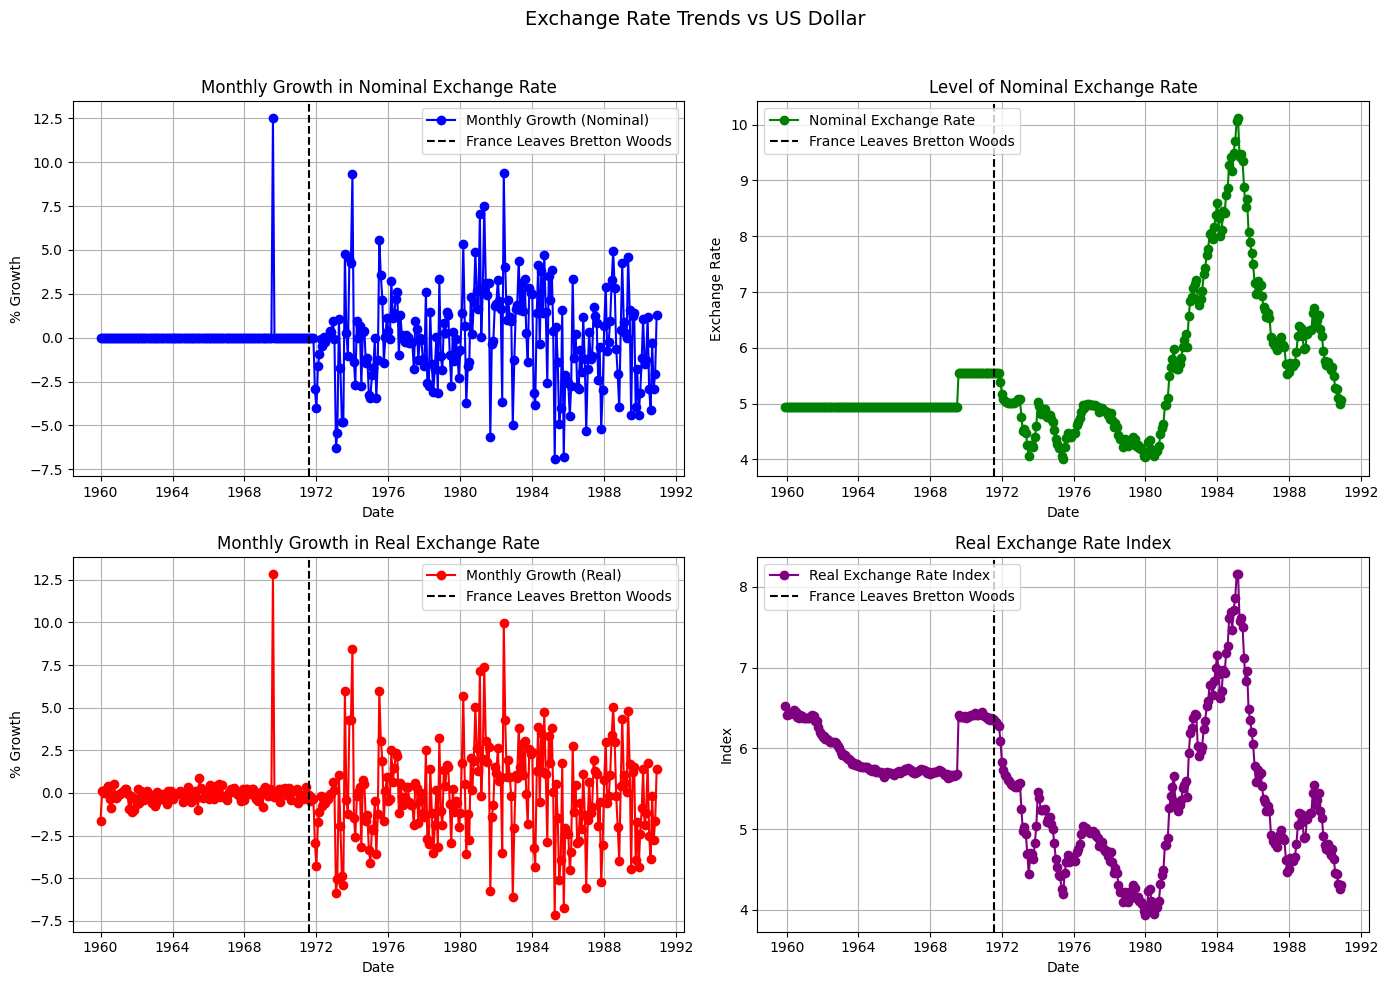

In [270]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
file_path = "../Data/full_merged_dataset_edit.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Drop missing values or interpolate
merged_df = merged_df.interpolate()

# Focus on recent years

bretton_woods_exit_date = pd.to_datetime("1971-08-01")

# Plot time series graphs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exchange Rate Trends vs US Dollar", fontsize=14)

# 1. Monthly Growth in Nominal Exchange Rate
if "Growth (%)" in merged_df.columns:
    axes[0, 0].plot(merged_df["Date"], merged_df["Growth (%)"], label="Monthly Growth (Nominal)", color="blue", marker="o")
    axes[0, 0].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
    axes[0, 0].set_title("Monthly Growth in Nominal Exchange Rate")
    axes[0, 0].set_ylabel("% Growth")
    axes[0, 0].legend()

# 2. Level of Nominal Exchange Rate
if "Nominal Exchange Rate" in merged_df.columns:
    axes[0, 1].plot(merged_df["Date"], merged_df["Nominal Exchange Rate"], label="Nominal Exchange Rate", color="green", marker="o")
    axes[0, 1].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
    axes[0, 1].set_title("Level of Nominal Exchange Rate")
    axes[0, 1].set_ylabel("Exchange Rate")
    axes[0, 1].legend()

# 3. Monthly Growth in Real Exchange Rate
if "Real Exchange Rate Growth (%)" in merged_df.columns:
    axes[1, 0].plot(merged_df["Date"], merged_df["Real Exchange Rate Growth (%)"], label="Monthly Growth (Real)", color="red", marker="o")
    axes[1, 0].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
    axes[1, 0].set_title("Monthly Growth in Real Exchange Rate")
    axes[1, 0].set_ylabel("% Growth")
    axes[1, 0].legend()

# 4. Real Exchange Rate Index
if "RER Index" in merged_df.columns:
    axes[1, 1].plot(merged_df["Date"], merged_df["RER Index"], label="Real Exchange Rate Index", color="purple", marker="o")
    axes[1, 1].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
    axes[1, 1].set_title("Real Exchange Rate Index")
    axes[1, 1].set_ylabel("Index")
    axes[1, 1].legend()

# Formatting
for ax in axes.flat:
    ax.set_xlabel("Date")
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


,Date,Nominal Exchange Rate,Growth (%),Real Exchange Rate Growth (%),RER Index,France Inflation (%),US Inflation (%),France IP Growth (%),US IP Growth (%),France YoY IP Growth (%),US YoY IP Growth (%),France Reserves Index,US Reserves Index_x,US Inflation Rate (%),US Reserves Index_y
1,1960-01-01,4.93706,0.0,-1.642377,6.413193,1.323986,-0.340136,-3.869477,2.917232,NaN,NaN,97.606777,100.385124,-0.340136,100.385124
2,1960-02-01,4.93706,0.0,0.110462,6.420277,0.230580,0.341297,2.343046,0.560316,NaN,NaN,100.000000,100.000000,0.341297,100.000000
3,1960-03-01,4.93706,0.0,0.000000,6.420277,0.000000,0.000000,0.352216,-0.229433,NaN,NaN,104.064027,99.761634,0.000000,99.761634
4,1960-04-01,4.93706,0.0,0.186470,6.432249,0.153380,0.340136,2.281369,-0.788436,NaN,NaN,108.406892,99.449889,0.340136,99.449889
5,1960-05-01,4.93706,0.0,0.230236,6.447059,-0.229708,0.000000,0.085788,-0.231788,NaN,NaN,116.699689,99.245643,0.000000,99.245643


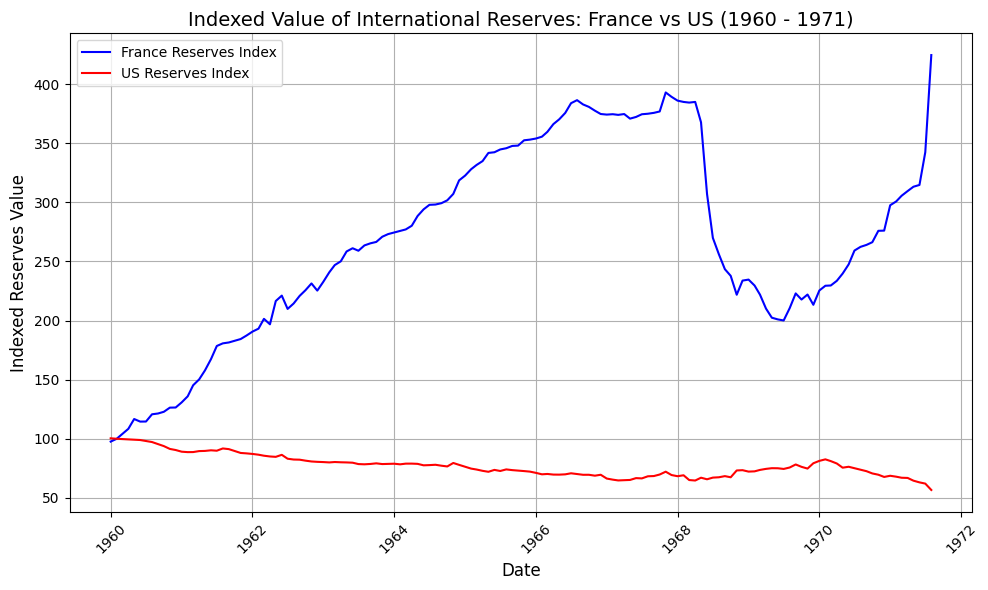

In [273]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged dataset
file_path = "../Data/full_merged_dataset_edit.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Filter data for the time period from January 1960 to August 15, 1971 (US exit from Bretton Woods)
start_date = "1960-01-01"
end_date = "1971-08-15"
filtered_df = merged_df[(merged_df["Date"] >= start_date) & (merged_df["Date"] <= end_date)]

# Check if the filtered DataFrame is empty and how many rows it has
display(filtered_df.head())

# Drop rows with missing values in the reserves columns
filtered_df = filtered_df.dropna(subset=["France Reserves Index", "US Reserves Index_x"])

# Plot the indexed value of international reserves for France and the US
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(filtered_df["Date"], filtered_df["France Reserves Index"], label="France Reserves Index", color="blue")
ax.plot(filtered_df["Date"], filtered_df["US Reserves Index_x"], label="US Reserves Index", color="red")


# Title and labels
ax.set_title("Indexed Value of International Reserves: France vs US (1960 - 1971)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Indexed Reserves Value", fontsize=12)
ax.legend()

# Formatting
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


# 5.2.2 Inflation and Industrial Production Graphs

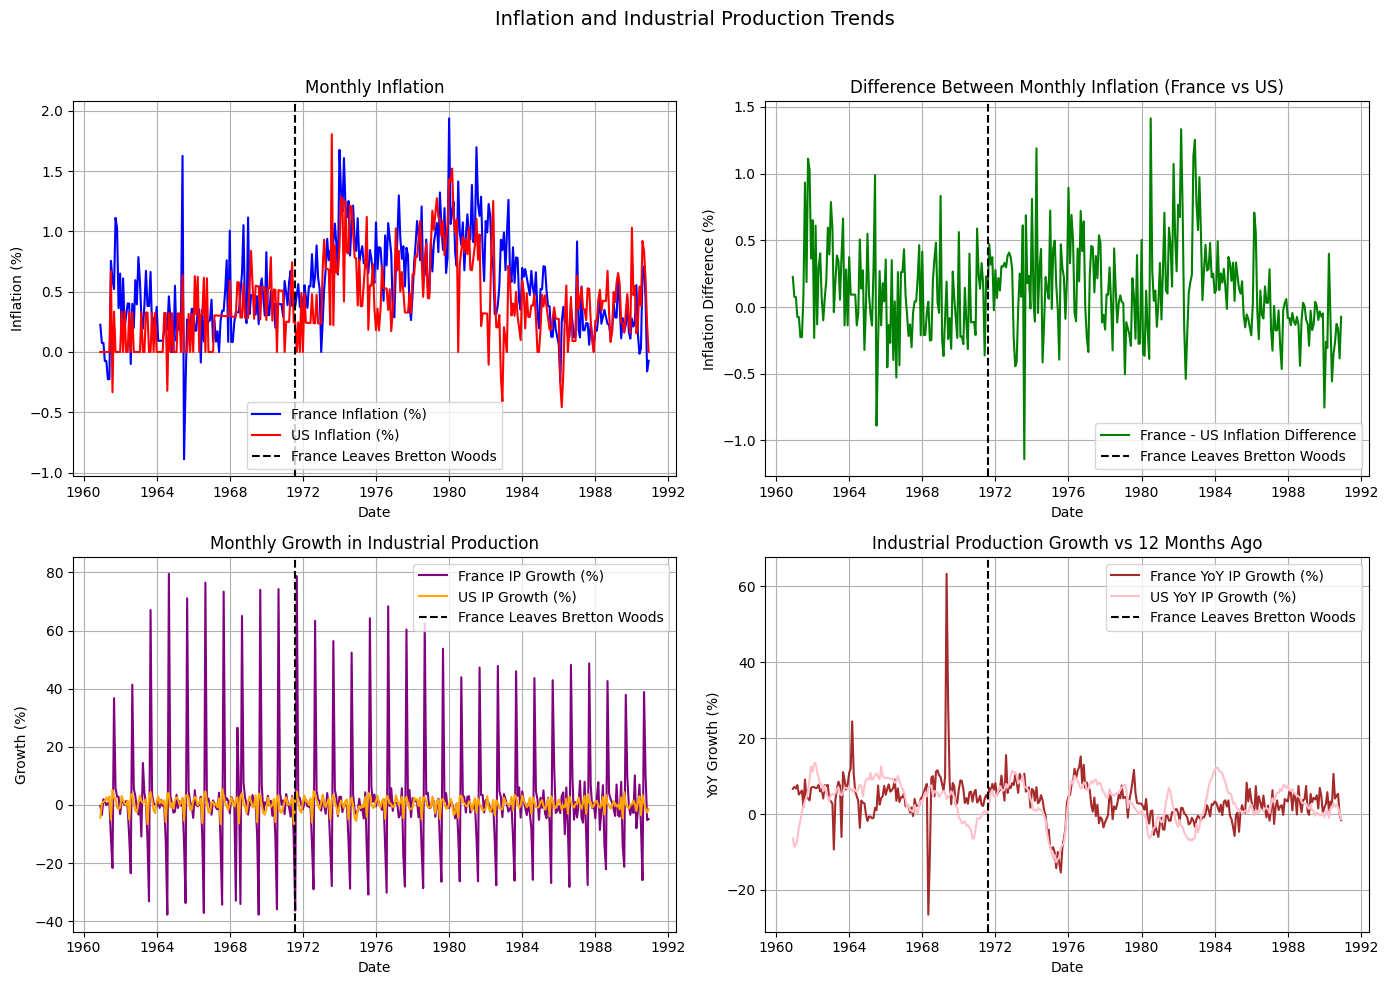

In [274]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged dataset
file_path = "../Data/full_merged_dataset_edit.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=["France Inflation (%)", "US Inflation Rate (%)", 
                                     "France IP Growth (%)", "US IP Growth (%)", 
                                     "France YoY IP Growth (%)", "US YoY IP Growth (%)"])

# Plot time series graphs for inflation and industrial production
bretton_woods_exit_date = pd.to_datetime("1971-08-01")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Inflation and Industrial Production Trends", fontsize=14)


# 1. Monthly Inflation (France and US)
axes[0, 0].plot(merged_df["Date"], merged_df["France Inflation (%)"], label="France Inflation (%)", color="blue")
axes[0, 0].plot(merged_df["Date"], merged_df["US Inflation Rate (%)"], label="US Inflation (%)", color="red")
axes[0, 0].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
axes[0, 0].set_title("Monthly Inflation")
axes[0, 0].set_ylabel("Inflation (%)")
axes[0, 0].legend()

# 2. Difference Between Monthly Inflation (France vs US)
merged_df["Inflation Difference"] = merged_df["France Inflation (%)"] - merged_df["US Inflation Rate (%)"]
axes[0, 1].plot(merged_df["Date"], merged_df["Inflation Difference"], label="France - US Inflation Difference", color="green")
axes[0, 1].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
axes[0, 1].set_title("Difference Between Monthly Inflation (France vs US)")
axes[0, 1].set_ylabel("Inflation Difference (%)")
axes[0, 1].legend()

# 3. Monthly Growth in Industrial Production (France and US)
axes[1, 0].plot(merged_df["Date"], merged_df["France IP Growth (%)"], label="France IP Growth (%)", color="purple")
axes[1, 0].plot(merged_df["Date"], merged_df["US IP Growth (%)"], label="US IP Growth (%)", color="orange")
axes[1, 0].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
axes[1, 0].set_title("Monthly Growth in Industrial Production")
axes[1, 0].set_ylabel("Growth (%)")
axes[1, 0].legend()

# 4. Industrial Production Growth Compared to 12 Months Ago (France and US)
axes[1, 1].plot(merged_df["Date"], merged_df["France YoY IP Growth (%)"], label="France YoY IP Growth (%)", color="brown")
axes[1, 1].plot(merged_df["Date"], merged_df["US YoY IP Growth (%)"], label="US YoY IP Growth (%)", color="pink")
axes[1, 1].axvline(x=bretton_woods_exit_date, color='black', linestyle='--', label='France Leaves Bretton Woods')
axes[1, 1].set_title("Industrial Production Growth vs 12 Months Ago")
axes[1, 1].set_ylabel("YoY Growth (%)")
axes[1, 1].legend()

# Formatting
for ax in axes.flat:
    ax.set_xlabel("Date")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


## 5.2.3 Comparison Statistics & Visualisation

,Before Bretton Woods (Std Dev),After Bretton Woods (Std Dev),Ratio (Before/After)
Growth (%),1.064066,2.778570,0.382955
Real Exchange Rate Growth (%),1.162126,2.790059,0.416524
France Inflation (%),0.312660,0.387441,0.806987
Inflation Difference,0.370513,0.370549,0.999903
France YoY IP Growth (%),7.469923,4.705564,1.587466


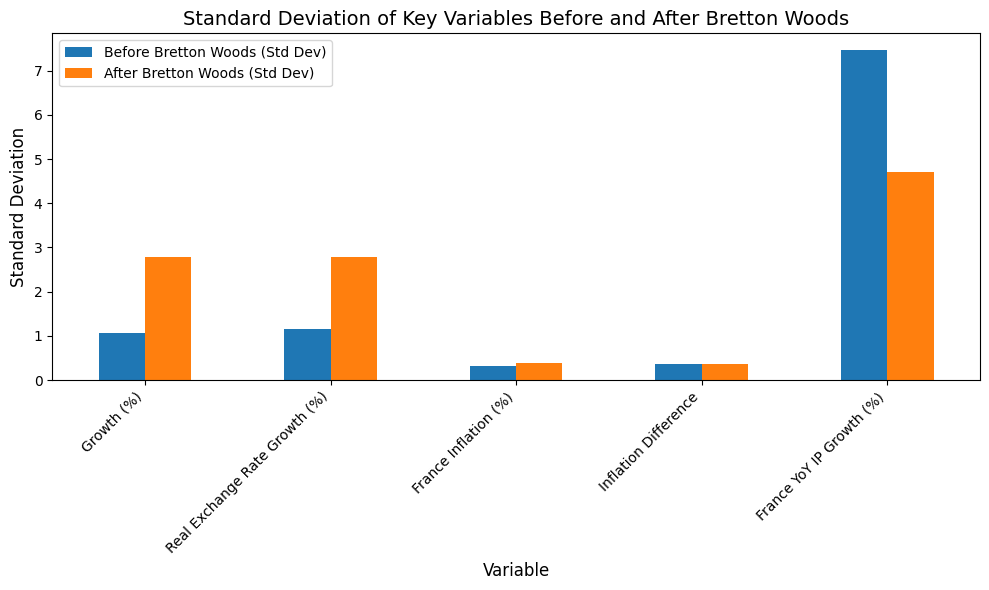

In [276]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
file_path = "../Data/full_merged_dataset_edit.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Create 'Inflation Difference' column by subtracting US inflation from France inflation
merged_df['Inflation Difference'] = merged_df['France Inflation (%)'] - merged_df['US Inflation Rate (%)']

# Filter the dataset for the two periods:
# 1. Before Bretton Woods (up to 06/1971)
before_bretton_woods_df = merged_df[merged_df["Date"] <= "1971-06-30"]

# 2. After Bretton Woods (from 03/1973 onwards)
after_bretton_woods_df = merged_df[merged_df["Date"] >= "1973-03-01"]

# Calculate standard deviations for each variable
variables = [
    "Growth (%)", "Real Exchange Rate Growth (%)", "France Inflation (%)",
    "Inflation Difference", "France YoY IP Growth (%)"
]

# Create a table for standard deviations and ratios
std_devs_before = {}
std_devs_after = {}
std_devs_ratio = {}

for var in variables:
    # Calculate the standard deviation before Bretton Woods (exclude missing values)
    std_devs_before[var] = before_bretton_woods_df[var].std()
    
    # Calculate the standard deviation after Bretton Woods (exclude missing values)
    std_devs_after[var] = after_bretton_woods_df[var].std()
    
    # Calculate the ratio of standard deviation before/after
    if std_devs_after[var] != 0:
        std_devs_ratio[var] = std_devs_before[var] / std_devs_after[var]
    else:
        std_devs_ratio[var] = None  # Handle case where the after std dev is zero

# Create a DataFrame for displaying results
std_dev_df = pd.DataFrame({
    "Before Bretton Woods (Std Dev)": std_devs_before,
    "After Bretton Woods (Std Dev)": std_devs_after,
    "Ratio (Before/After)": std_devs_ratio
})

# Print the table of standard deviations and ratios
display(std_dev_df)

# Plot the standard deviations before and after Bretton Woods
fig, ax = plt.subplots(figsize=(10, 6))
std_dev_df[["Before Bretton Woods (Std Dev)", "After Bretton Woods (Std Dev)"]].plot(kind="bar", ax=ax)

# Adding chart details
ax.set_title("Standard Deviation of Key Variables Before and After Bretton Woods", fontsize=14)
ax.set_ylabel("Standard Deviation", fontsize=12)
ax.set_xlabel("Variable", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show plot
plt.show()


C:\Users\eleph\AppData\Local\Temp\ipykernel_33556\2256996589.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_std_devs[var] = merged_df[var].resample('Y').std()


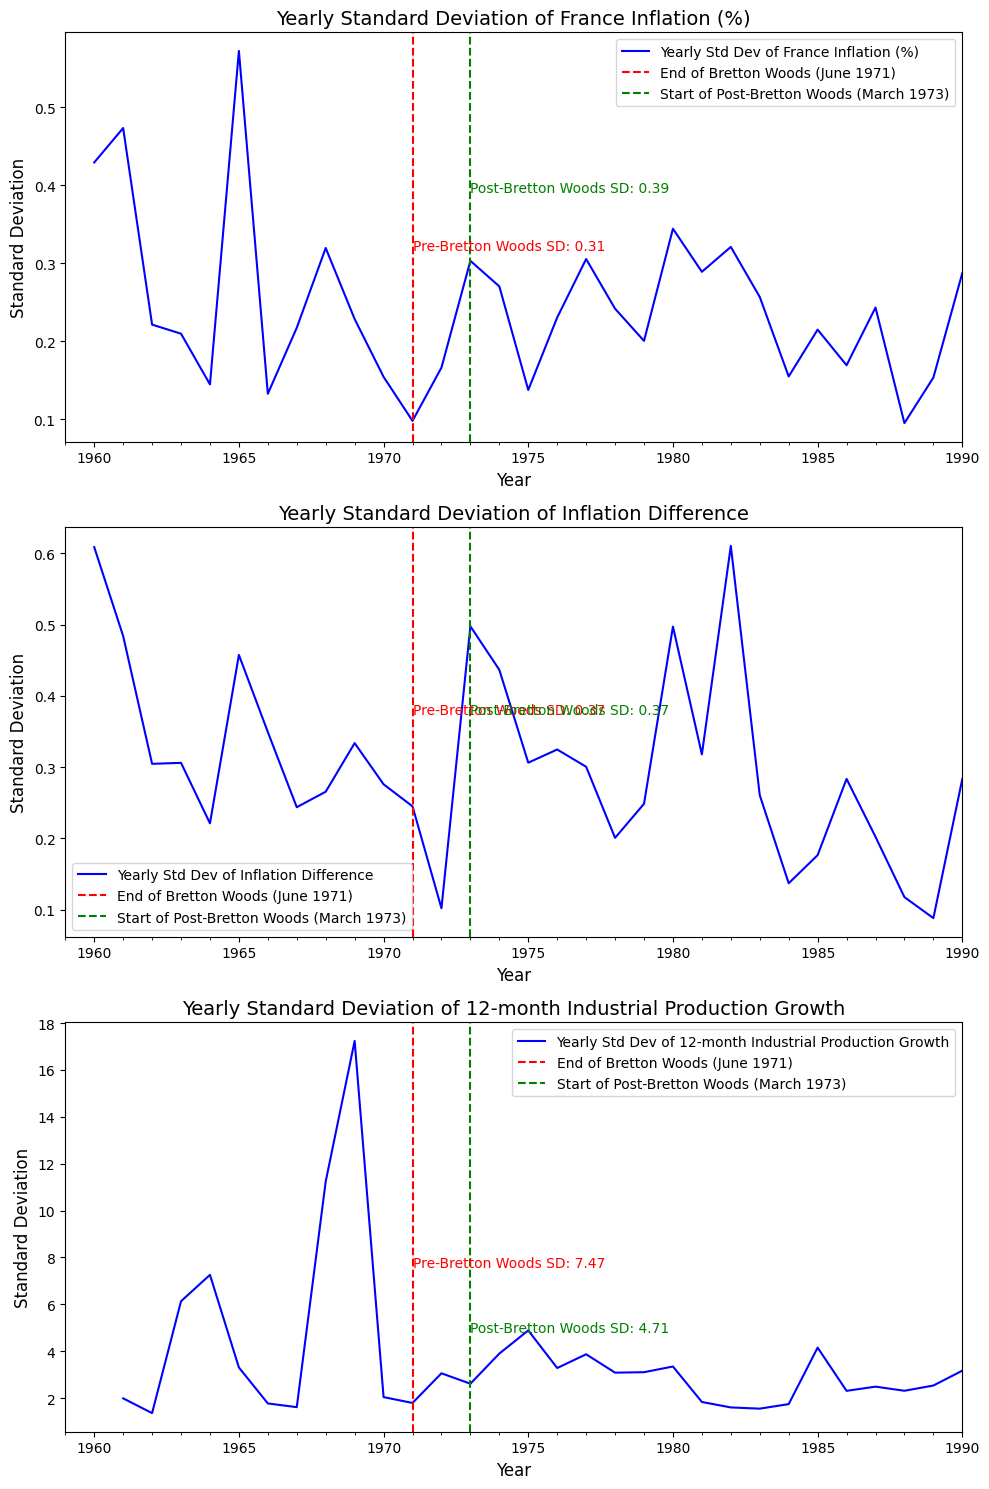

In [277]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "../Data/full_merged_dataset_edit.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Create 'Inflation Difference' column by subtracting US inflation from France inflation
merged_df['Inflation Difference'] = merged_df['France Inflation (%)'] - merged_df['US Inflation Rate (%)']

# Calculate the 12-month industrial production growth
merged_df['12-month Industrial Production Growth'] = merged_df['France YoY IP Growth (%)']

# Set the Date column as the index for easier resampling
merged_df.set_index('Date', inplace=True)

# Create a list of variables to plot
variables = ['France Inflation (%)', 'Inflation Difference', '12-month Industrial Production Growth']

# Calculate yearly standard deviations for each variable
yearly_std_devs = {}
for var in variables:
    yearly_std_devs[var] = merged_df[var].resample('Y').std()

# Extract the standard deviation for the periods before and after Bretton Woods
std_devs_before = {}
std_devs_after = {}

# Split the data into periods: Before and After Bretton Woods
before_bretton_woods_df = merged_df[merged_df.index <= "1971-06-30"]
after_bretton_woods_df = merged_df[merged_df.index >= "1973-03-01"]

# Calculate the standard deviation for these periods
for var in variables:
    std_devs_before[var] = before_bretton_woods_df[var].std()
    std_devs_after[var] = after_bretton_woods_df[var].std()

# Plot the yearly standard deviations
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, var in enumerate(variables):
    ax = axes[i]
    
    # Plot the yearly standard deviations for the variable
    yearly_std_devs[var].plot(ax=ax, label=f"Yearly Std Dev of {var}", color="blue")
    
    # Indicate the pre and post-Bretton Woods standard deviations
    ax.axvline(before_bretton_woods_df.index[-1], color='red', linestyle='--', label="End of Bretton Woods (June 1971)")
    ax.axvline(after_bretton_woods_df.index[0], color='green', linestyle='--', label="Start of Post-Bretton Woods (March 1973)")
    
    # Add text annotations for the standard deviations
    ax.text(before_bretton_woods_df.index[-1], std_devs_before[var], f"Pre-Bretton Woods SD: {std_devs_before[var]:.2f}",
            color='red', fontsize=10, verticalalignment='bottom')
    ax.text(after_bretton_woods_df.index[0], std_devs_after[var], f"Post-Bretton Woods SD: {std_devs_after[var]:.2f}",
            color='green', fontsize=10, verticalalignment='bottom')
    
    # Set titles and labels
    ax.set_title(f"Yearly Standard Deviation of {var}", fontsize=14)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Standard Deviation", fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()


# 5.2.4 Regression Analysis

Regression: 6m_std_inflation ~ 6m_std_rer
                            OLS Regression Results                            
Dep. Variable:       6m_std_inflation   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.528
Date:                Mon, 24 Mar 2025   Prob (F-statistic):              0.113
Time:                        13:36:50   Log-Likelihood:                 191.33
No. Observations:                 356   AIC:                            -378.7
Df Residuals:                     354   BIC:                            -370.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

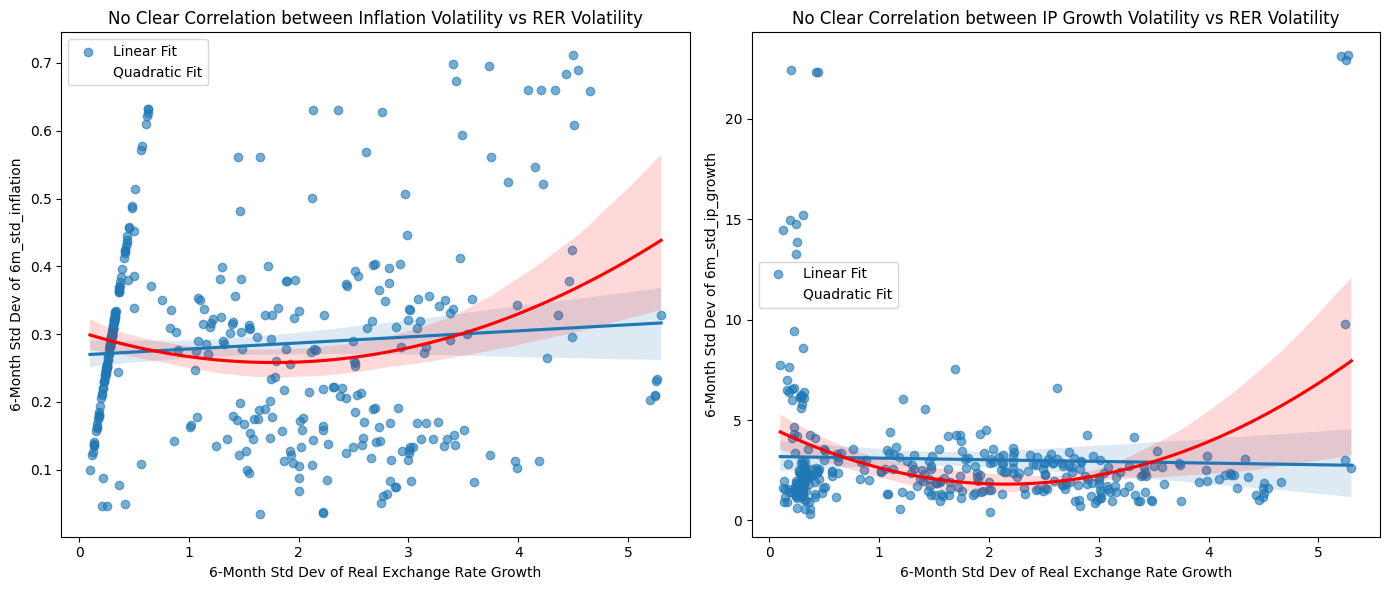

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load dataset
merged_df = pd.read_csv("../Data/full_merged_dataset_edit.csv")

# Convert Date to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"], format='%Y-%m')
merged_df.set_index("Date", inplace=True)

# Compute 6-month rolling standard deviations
merged_df["Inflation Diff"] = merged_df["France Inflation (%)"] - merged_df["US Inflation (%)"]
merged_df["6m_std_rer"] = merged_df["Real Exchange Rate Growth (%)"].rolling(window=6).std()
merged_df["6m_std_inflation"] = merged_df["Inflation Diff"].rolling(window=6).std()
merged_df["6m_std_ip_growth"] = merged_df["France YoY IP Growth (%)"].rolling(window=6).std()

# Drop NaN values due to rolling calculations
merged_df.dropna(inplace=True)

# Regression analysis
def run_regression(dependent_var, independent_var):
    X = sm.add_constant(merged_df[independent_var])  # Add constant for intercept
    y = merged_df[dependent_var]
    model = sm.OLS(y, X).fit()
    print(model.summary())
    return model

# Run regressions
print("Regression: 6m_std_inflation ~ 6m_std_rer")
inflation_model = run_regression("6m_std_inflation", "6m_std_rer")

print("Regression: 6m_std_ip_growth ~ 6m_std_rer")
ip_growth_model = run_regression("6m_std_ip_growth", "6m_std_rer")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, dep_var, title in zip(axes, ["6m_std_inflation", "6m_std_ip_growth"], 
                              ["No Clear Correlation between Inflation Volatility vs RER Volatility", "No Clear Correlation between IP Growth Volatility vs RER Volatility"]):
    sns.regplot(x=merged_df["6m_std_rer"], y=merged_df[dep_var], ax=ax, order=1, scatter_kws={'alpha':0.6}, label='Linear Fit')
    sns.regplot(x=merged_df["6m_std_rer"], y=merged_df[dep_var], ax=ax, order=2, scatter_kws={'alpha':0}, label='Quadratic Fit', color='red')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("6-Month Std Dev of Real Exchange Rate Growth")
    ax.set_ylabel(f"6-Month Std Dev of {dep_var}")

plt.tight_layout()
plt.show()

# Q6.2

In [279]:
# Load the dataset
file_path = "../Data/International_Financial_Statistics_ UK and Germany.xlsx"  # Update this with your actual file path
q6_data = pd.read_excel(file_path, header=None, engine="openpyxl")

In [281]:
german_exchange_rate_row = q6_data.iloc[3, 2:]  # The exchange rates start from the 3rd column (index 2)
german_cpi_row = q6_data.iloc[4, 2:]

# Convert the exchange rates and cpi into a list
german_exchange_rate_list = german_exchange_rate_row.tolist()
german_cpi_list = german_cpi_row.tolist()

#Convert exchange rates and cpi into pandas
german_nominal = pd.Series(german_exchange_rate_list)
german_cpi_pandas = pd.Series(german_cpi_list)

In [282]:
uk_exchange_rate_row = q6_data.iloc[6, 2:]  # The exchange rates start from the 3rd column (index 2)
uk_cpi_row = q6_data.iloc[7, 2:]

# Convert the exchange rates and cpi into a list
uk_exchange_rate_list = uk_exchange_rate_row.tolist()
uk_cpi_list = uk_cpi_row.tolist()

# Convert the exchange rates and cpi into pandas
uk_nominal = pd.Series(uk_exchange_rate_list)
uk_cpi_pandas = pd.Series(uk_cpi_list)

In [283]:
# gbp to gdm (german deutsche mark) exchange rate 
gbp_to_german = [gbp / eur for gbp, eur in zip(german_nominal, uk_nominal)]

In [ ]:
# finding UK to german real exchange rate
gbp_to_german_rer = gbp_to_german * (german_cpi_pandas/uk_cpi_pandas)

In [285]:
# finding the date as a panda table 
date_row1 = q6_data.iloc[1, 2:]
date_list1 = date_row1.tolist()

#### Finding the GBP to GDM Nominal Exchange Rate

In [287]:
gbp_to_gdm = pd.DataFrame({
    'Date': date_list1,
    'GBP_to_GDM': gbp_to_german
})

In [299]:
# Sample DataFrame (Ensure 'Date' is datetime type)
gbp_to_gdm["Date"] = pd.to_datetime(gbp_to_gdm["Date"])

# Create the plot
plot = (ggplot(gbp_to_gdm) +
    geom_line(aes(x='Date', y='GBP_to_GDM'), color='blue') +
    labs(title="GBP to German Nominal Exchange Rate", x="Date", y="Exchange Rate") +
    theme_minimal())

# ✅ Correct way to display the plot
plot # This will render the plot in Jupyter Notebook or terminal


#### Finding the GBP to GDM Real Exchange Rate

In [291]:
gbp_to_gdm_rer = pd.DataFrame({
    'Date': date_list1,
    'GBP_to_GDM_RER': gbp_to_german_rer
})

In [298]:
gbp_to_gdm_rer['Date'] = pd.to_datetime(gbp_to_gdm_rer['Date'])
                                        
# Create the plot
plot0 = (ggplot(gbp_to_gdm_rer) +
    geom_line(aes(x='Date', y='GBP_to_GDM_RER'), color='blue') +
    labs(title="GBP to Real German Exchange Rate", x="Date", y="Exchange Rate") +
    theme_minimal())

plot0

#### Difference in Inflation between Germany and the UK 

In [ ]:
uk_inflation = uk_cpi_pandas.pct_change() * 100
uk_inflation_table = pd.DataFrame({
    'Date': date_list1,
    'uk_inflation': uk_inflation
})
uk_inflation_table

germany_inflation = german_cpi_pandas.pct_change() * 100
germany_inflation_table = pd.DataFrame({
    'Date': date_list1,
    'germany_inflation': germany_inflation

})

In [ ]:
inflation_table = pd.merge(uk_inflation_table, germany_inflation_table, on='Date')

# Melt the DataFrame to have 'Source' as a categorical variable for coloring
inflation_table_melted = pd.melt(inflation_table, id_vars=["Date"], 
                                 value_vars=["uk_inflation", "germany_inflation"],
                                 var_name="Country", value_name="Inflation")

# Setup lets-plot for HTML rendering


# Create the plot
plot5 = ggplot(inflation_table_melted) + \
    geom_line(aes(x='Date', y='Inflation', color='Country'), size=1) + \
    labs(title="UK vs Germany Inflation", x="Date", y="Inflation (%)") + \
    theme_minimal() + \
    scale_color_manual(values={"uk_inflation": "red", "germany_inflation": "blue"})  # Set the colors for each country

# Display the plot
plot5.show()

#### Difference in the Industrial Production Growth between Germany and the UK

In [ ]:
uk_industrial_production_row = q6_data.iloc[5, 2:]
uk_industrial_production_list = uk_industrial_production_row.tolist()
uk_industrial_production_pandas =pd.Series(uk_industrial_production_list)
uk_ip_growth = uk_industrial_production_pandas.pct_change() * 100

germany_industrial_production_row = q6_data.iloc[2, 2:]
germany_industrial_production_list = germany_industrial_production_row.tolist()
germany_industrial_production_pandas = pd.Series(germany_industrial_production_list)
germany_ip_growth = germany_industrial_production_pandas.pct_change() * 100 

In [ ]:
uk_ip_growth_table = pd.DataFrame({
    'Date': date_list1,
    'uk_ip_growth': uk_ip_growth
})

germany_ip_growth_table = pd.DataFrame({
    'Date': date_list1,
    'germany_ip_growth': germany_ip_growth
})

growth_table = pd.merge(germany_ip_growth_table, uk_ip_growth_table, on='Date')

In [ ]:
# Melt the DataFrame to long format for ggplot
growth_table_melted = pd.melt(growth_table, id_vars=["Date"], 
                              value_vars=["uk_ip_growth", "germany_ip_growth"], 
                              var_name="Country", value_name="IP_Growth")

# Create the plot
plot = ggplot(growth_table_melted) + \
    geom_line(aes(x='Date', y='IP_Growth', color='Country'), size=1) + \
    labs(title="UK vs Germany Industrial Production Growth", x="Date", y="Industrial Production Growth (%)") + \
    theme_minimal() + \
    scale_color_manual(values={"uk_ip_growth": "red", "germany_ip_growth": "blue"})  # Set the colors for each country

# Display the plot
plot.show()